In [35]:
library('Seurat')
library(Matrix)
library(Matrix.utils)
library(plyr)
library(dplyr)
library(Seurat)
library(sctransform)
library(igraph)
library(factoextra)
library(ComplexHeatmap)
library(circlize)
library(EpicTools)
require(Hmisc)
require(dplyr)
require(openxlsx)
require(ggplot2)
library(ggpubr)
require(cowplot)
library(data.table)
library(RColorBrewer)
library(rowr)
library(SingleR)
library(scater)
library(pheatmap)
#library(nichenetr)
library(tidyverse)

In [4]:
count = read.table('GSE176269_CovidStudy_rawCounts_061721_(1).txt',header =T,sep = '\t',row.names = 1)

In [5]:
cli = read.table('GSE176269_CovidStudy_phenotype_061721.txt',header =T,sep = '\t',row.names = 1)

In [6]:
data.object <- CreateSeuratObject(counts = count, project = "test", min.cells = 3, min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [7]:
pbmc_small <- AddMetaData(
  object = data.object,
  metadata = cli
)

In [8]:
set.seed(1345)

In [9]:
covid_combined <- PercentageFeatureSet(pbmc_small, pattern = "^MT-", col.name = "percent.mt")

In [10]:
covid_combined <- PercentageFeatureSet(covid_combined, pattern = "^RPS", col.name = "percent.rps")
covid_combined <- PercentageFeatureSet(covid_combined, pattern = "^RPL", col.name = "percent.rpl")
covid_combined <- PercentageFeatureSet(covid_combined, pattern = "^RNA\\d8S5", col.name = "percent.rrna")

In [22]:
# pbmc.list <- SplitObject(covid_combined, split.by="sampID")
# for(i in 1:length(pbmc.list)) {
#   pbmc.list[[i]] <- NormalizeData(pbmc.list[[i]],verbose=FALSE)
#   pbmc.list[[i]] <- FindVariableFeatures(pbmc.list[[i]],selection.method="vst",verbose=FALSE)
# }

# AllBatch.anchors <- FindIntegrationAnchors(object.list = pbmc.list, dims = 1:30,k.filter=80)
# pbmc <- IntegrateData(anchorset = AllBatch.anchors, dims = 1:30)

# DefaultAssay(pbmc) <- "integrated"
# pbmc <- ScaleData(pbmc, verbose = T, do.center=F,split.by = 'sampID')
# pbmc <- RunPCA(pbmc, npcs = 50, verbose = T)
# pbmc <- RunUMAP(pbmc, reduction = "pca", dims = 1:30,
#                 reduction.name = 'seurat_umap', reduction.key = 'seurat_umap')

In [70]:
options(repr.plot.height = 4,repr.plot.width = 4)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


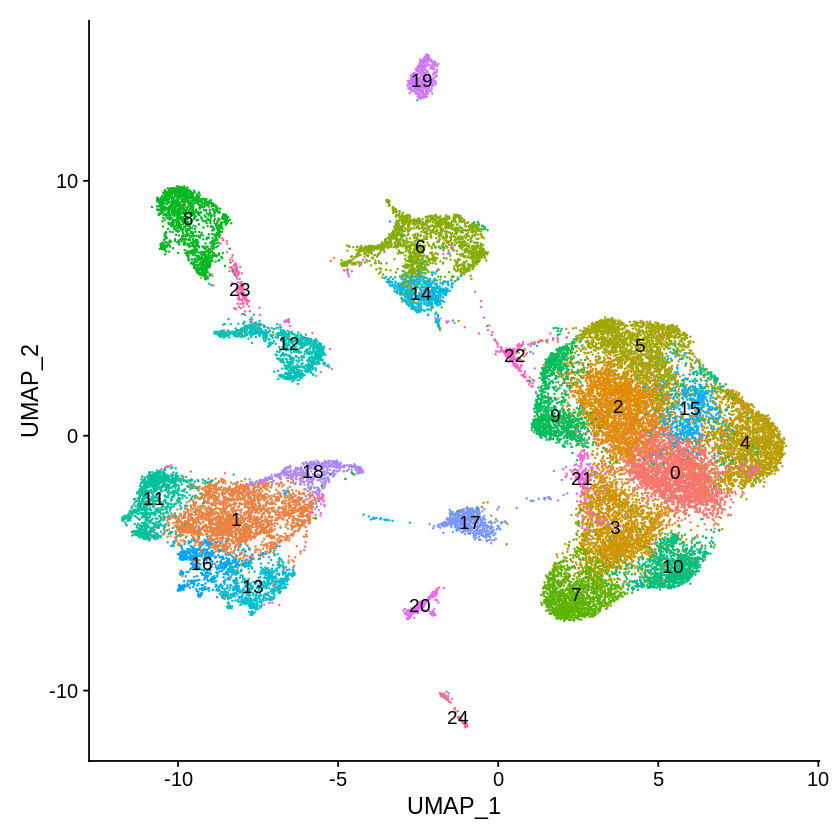

In [11]:
covid_combined <- SCTransform(covid_combined, vars.to.regress = c("percent.mt", "percent.rps", "percent.rpl", "percent.rrna", "nCount_RNA", "nFeature_RNA"), verbose = FALSE, return.only.var.genes = TRUE) #expect "iteration limit reached" warning unless suppressed per https://github.com/satijalab/seurat/issues/1426
covid_combined <- RunPCA(covid_combined, verbose = FALSE)
covid_combined <- RunUMAP(covid_combined, dims = 1:50, verbose = FALSE)
covid_combined <- FindNeighbors(covid_combined, dims = 1:50, verbose = FALSE)
covid_combined <- FindClusters(covid_combined, resolution = 1, verbose = FALSE)

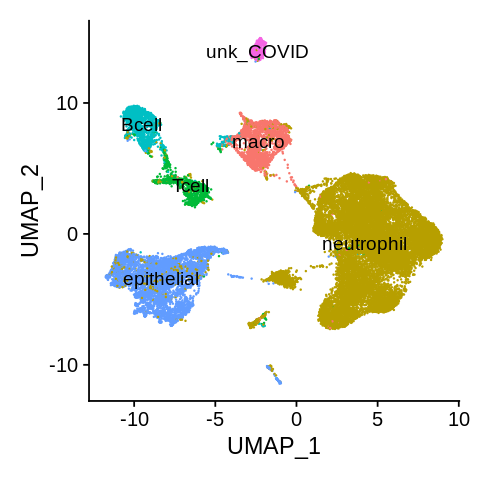

In [71]:
DimPlot(covid_combined, label = TRUE) + NoLegend()

In [14]:
save(covid_combined,file = 'covid_combined2.rda')

In [39]:
new_dotplot <- function(object = NULL, features = NULL, group.by = NULL, genes.on.x = TRUE, 
                        size.breaks.values = NULL, color.breaks.values = c(-3, -2, -1, 0, 1, 2, 3), shape.scale = 12, 
                        dend_x_var = "Average expression", dend_y_var = "Average expression",
                        cols.use = c("lightgrey", "blue"), scale.by = "radius", col.min = -2.5, col.max = 2.5,
                        dot.min = 0) {
  scale.func <- switch(EXPR = scale.by, size = scale_size, 
                       radius = scale_radius, stop("'scale.by' must be either 'size' or 'radius'"))
  
  data.features <- FetchData(object = object, vars = features)
  object[[group.by, drop = TRUE]]
  data.features$id <- object[[group.by, drop = TRUE]]
  if (!is.factor(x = data.features$id)) {
    data.features$id <- factor(x = data.features$id)
  }
  id.levels <- levels(x = data.features$id)
  data.features$id <- as.vector(x = data.features$id)
  data.plot <- lapply(X = unique(x = data.features$id), FUN = function(ident) {
    data.use <- data.features[data.features$id == ident, 
                              1:(ncol(x = data.features) - 1), drop = FALSE]
    avg.exp <- apply(X = data.use, MARGIN = 2, FUN = function(x) {
      return(mean(x = expm1(x = x)))
    })
    pct.exp <- apply(X = data.use, MARGIN = 2, FUN = Seurat:::PercentAbove, 
                     threshold = 0)
    return(list(avg.exp = avg.exp, pct.exp = pct.exp))
  })
  names(x = data.plot) <- unique(x = data.features$id)
  data.plot <- lapply(X = names(x = data.plot), FUN = function(x) {
    data.use <- as.data.frame(x = data.plot[[x]])
    data.use$features.plot <- rownames(x = data.use)
    data.use$id <- x
    return(data.use)
  })
  
  data.plot <- do.call(what = "rbind", args = data.plot)
  if (!is.null(x = id.levels)) {
    data.plot$id <- factor(x = data.plot$id, levels = id.levels)
  }
  avg.exp.scaled <- sapply(X = unique(x = data.plot$features.plot), 
                           FUN = function(x) {
                             data.use <- data.plot[data.plot$features.plot == 
                                                     x, "avg.exp"]
                             data.use <- scale(x = data.use)
                             data.use <- MinMax(data = data.use, min = col.min, 
                                                max = col.max)
                             return(data.use)
                           })
  avg.exp.scaled <- as.vector(x = t(x = avg.exp.scaled))
  data.plot$avg.exp.scaled <- avg.exp.scaled
  data.plot$features.plot <- factor(x = data.plot$features.plot, 
                                    levels = rev(x = features))
  data.plot$pct.exp[data.plot$pct.exp < dot.min] <- NA
  data.plot$pct.exp <- data.plot$pct.exp * 100
  
  if(genes.on.x){
    data.final <- data.frame(features.plot = data.plot$features.plot, id = data.plot$id)
    data.final <- cbind(data.final, data.plot[,c(2,5)])
  }
  else {
    data.final <- data.frame(id = data.plot$id, features.plot = data.plot$features.plot)
    data.final <- cbind(data.final, data.plot[,c(2,5)])
  }
  colnames(data.final)[3:4] <- c("Percent expressed", "Average expression")
  save(data.final,file = 'res1.rda')
}

In [72]:
var.feature = covid_combined@assays$SCT@var.features

In [75]:
new_dotplot <- function(object = NULL, features = NULL, group.by = NULL, genes.on.x = TRUE, 
                        size.breaks.values = NULL, color.breaks.values = c(-3, -2, -1, 0, 1, 2, 3), shape.scale = 12, 
                        dend_x_var = "Average expression", dend_y_var = "Average expression",
                        cols.use = c("lightgrey", "blue"), scale.by = "size", col.min = -2.5, col.max = 2.5,
                        dot.min = 0) {
  scale.func <- switch(EXPR = scale.by, size = scale_size, 
                       radius = scale_radius, stop("'scale.by' must be either 'size' or 'radius'"))
  
  data.features <- FetchData(object = object, vars = features)
  object[[group.by, drop = TRUE]]
  data.features$id <- object[[group.by, drop = TRUE]]
  if (!is.factor(x = data.features$id)) {
    data.features$id <- factor(x = data.features$id)
  }
  id.levels <- levels(x = data.features$id)
  data.features$id <- as.vector(x = data.features$id)
  data.plot <- lapply(X = unique(x = data.features$id), FUN = function(ident) {
    data.use <- data.features[data.features$id == ident, 
                              1:(ncol(x = data.features) - 1), drop = FALSE]
    avg.exp <- apply(X = data.use, MARGIN = 2, FUN = function(x) {
      return(mean(x = expm1(x = x)))
    })
    pct.exp <- apply(X = data.use, MARGIN = 2, FUN = Seurat:::PercentAbove, 
                     threshold = 0)
    return(list(avg.exp = avg.exp, pct.exp = pct.exp))
  })
  names(x = data.plot) <- unique(x = data.features$id)
  data.plot <- lapply(X = names(x = data.plot), FUN = function(x) {
    data.use <- as.data.frame(x = data.plot[[x]])
    data.use$features.plot <- rownames(x = data.use)
    data.use$id <- x
    return(data.use)
  })
  
  data.plot <- do.call(what = "rbind", args = data.plot)
  if (!is.null(x = id.levels)) {
    data.plot$id <- factor(x = data.plot$id, levels = id.levels)
  }
  avg.exp.scaled <- sapply(X = unique(x = data.plot$features.plot), 
                           FUN = function(x) {
                             data.use <- data.plot[data.plot$features.plot == 
                                                     x, "avg.exp"]
                             data.use <- scale(x = data.use)
                             data.use <- MinMax(data = data.use, min = col.min, 
                                                max = col.max)
                             return(data.use)
                           })
  avg.exp.scaled <- as.vector(x = t(x = avg.exp.scaled))
  data.plot$avg.exp.scaled <- avg.exp.scaled
  data.plot$features.plot <- factor(x = data.plot$features.plot, 
                                    levels = rev(x = features))
  data.plot$pct.exp[data.plot$pct.exp < dot.min] <- NA
  data.plot$pct.exp <- data.plot$pct.exp * 100
  
  if(genes.on.x){
    data.final <- data.frame(features.plot = data.plot$features.plot, id = data.plot$id)
    data.final <- cbind(data.final, data.plot[,c(2,5)])
  }
  else {
    data.final <- data.frame(id = data.plot$id, features.plot = data.plot$features.plot)
    data.final <- cbind(data.final, data.plot[,c(2,5)])
  }
  colnames(data.final)[3:4] <- c("Percent expressed", "Average expression")
  save(data.final,file = 'res.rda')
}

In [76]:
new_dotplot(covid_combined, features = var.feature, group.by = "seurat_clusters", shape.scale = 60, color.breaks.values = c(-2, -1, 0, 1, 2), size.breaks.values = c(0, 25, 50, 75, 100))

In [77]:
load('res.rda')

In [78]:
dim(data.final)

[1] 75000     4

In [74]:
# librres.rdagplot2)
# ggplot(data.final,aes(x=features.plot,y=id))+
#   geom_point(aes(size=`Percent expressed`,
#                  color=`Average expression`))+
#   theme_bw()+
#   theme(panel.grid = element_blank(),
#         axis.text.x=element_text(angle=90,hjust = 1,vjust=0.5))+
#   scale_color_gradient(low="lightgrey",high="blue")+
#   labs(x=NULL,y=NULL)+
#   guides(size=guide_legend(order=3))
# df<-data.final[,c(1,2,4)]
# df1<-reshape2::dcast(df,id~features.plot,value.var = "Average expression")
# rownames(df1)<-df1$id

In [79]:
df<-data.final[,c(1,2,4)]
df1<-reshape2::dcast(df,id~features.plot,value.var = "Average expression")
rownames(df1)<-df1$id

In [90]:
df1.1<-df1[,2:25]
df1.1.clust<-hclust(dist(df1.1))

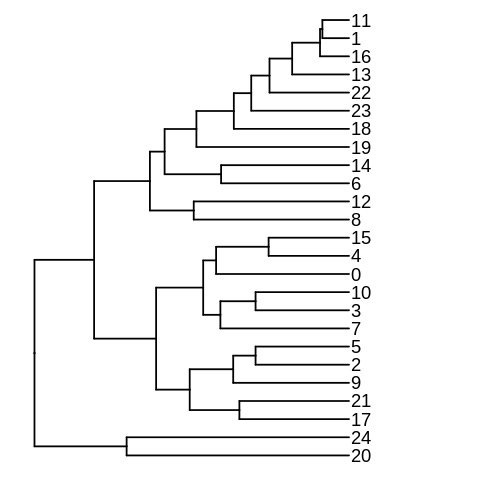

In [91]:
library(ggtree)
p2<-ggtree(df1.1.clust)
p2+
  geom_tiplab()+
  xlim(NA,7)

In [93]:
library(ape)
tree = as.phylo(df1.1.clust)# 聚类结果转成系统发育格式

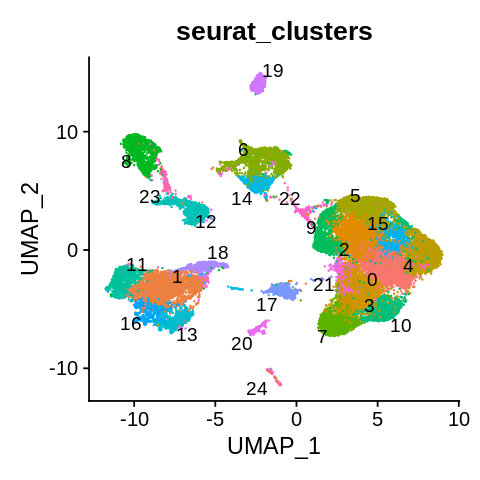

In [94]:
DimPlot(covid_combined, label = TRUE,group.by = 'seurat_clusters',repel = T) + NoLegend()

#### 自定义细胞信息

In [226]:
node = c(1,11,13,16,18,8,23,12,6,14,24,20,17,7,10,3,0,21,4,2,15,9,5,22,19)
#group = c(rep('cov' ,1),rep('epi',5),rep('imm' ,3),rep('mac' ,2),rep('neu' ,14))
group = c(rep('c' ,1),rep('a' ,3),rep('e' ,14),rep('d' ,2),rep('b',5))
#group = c(rep('c' ,3),rep('b',7),rep('a' ,6),rep('d' ,9))
group.info = data.frame(node,group)

In [227]:
groupInfo <- split(group.info$node, group.info$group)
tree <- groupOTU(tree, groupInfo)

In [228]:
options(repr.plot.height = 5,repr.plot.width = 5)

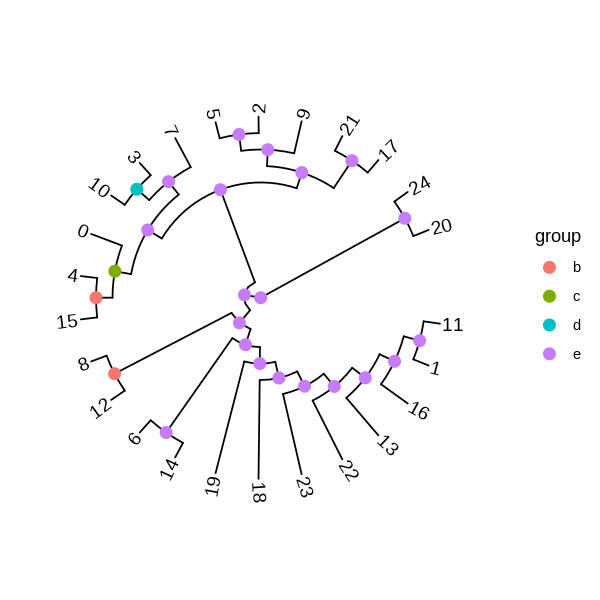

In [229]:
ggtree(tree,branch.length = "none",layout = "circular") + xlim(0,12)+ 
    geom_tiplab2(offset=0.1,size =4) +
    geom_nodepoint(aes(color=group), size=3) 

#### 胡鹏老师的代码

In [237]:
feature = var.feature[3:15]

In [239]:
cluster_pc_res = function(t, pcs = 1:50, res = 2) {
    t <- RunTSNE(t, dims.use = pcs, do.fast = T)
    t <- FindClusters(t, pc.use = pcs, resolution = res, save.SNN = T, do.sparse = T)
}
scNuc.pc30 <- cluster_pc_res(covid_combined, pcs = 1:50)

Warning message:
“The following arguments are not used: pc.use, save.SNN, do.sparse”
Warning message:
“The following arguments are not used: pc.use, save.SNN, do.sparse”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29341
Number of edges: 1011295

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8277
Number of communities: 37
Elapsed time: 5 seconds


In [259]:
library("reshape2")
plot_vln <- function(t, my.genes3) {
    d <- as.matrix(t@assays$SCT@data[intersect(my.genes3, rownames(t@assays$SCT@data)), ])
    dd <- melt(d, id = row.names)
    dd <- dd %>% dplyr::rename(gene = Var1, cell = Var2)
    dd$tree.ident <- t@active.ident[dd$cell]
    str(dd$tree.ident)
    dd$gene <- factor(dd$gene, levels = intersect(my.genes3, rownames(t@assays$SCT@data)))
    ggplot(dd, aes(tree.ident, value, fill = tree.ident)) + geom_violin(scale = "width", 
        trim = T, alpha = 0.8, adjust = 1) + facet_wrap(~gene, scales = "free_y", 
        ncol = 1, strip.position = "right") + theme(strip.background = element_blank(), 
        strip.placement = "outside", axis.text.y = element_blank(), axis.title.y = element_blank(), 
        strip.text.y = element_text(colour = "red", angle = 360, size = 10), 
        legend.position = "none", panel.grid = element_blank(), panel.border = element_blank()) + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size = rel(0.9)), 
            legend.position = "none") + xlab("")  + theme_classic() + NoLegend()
}

In [260]:
Idents(scNuc.pc30) = 'cellType'

 Factor w/ 28 levels "M1-mac-exp","G5c_aged",..: 1 1 1 1 1 1 1 1 1 1 ...


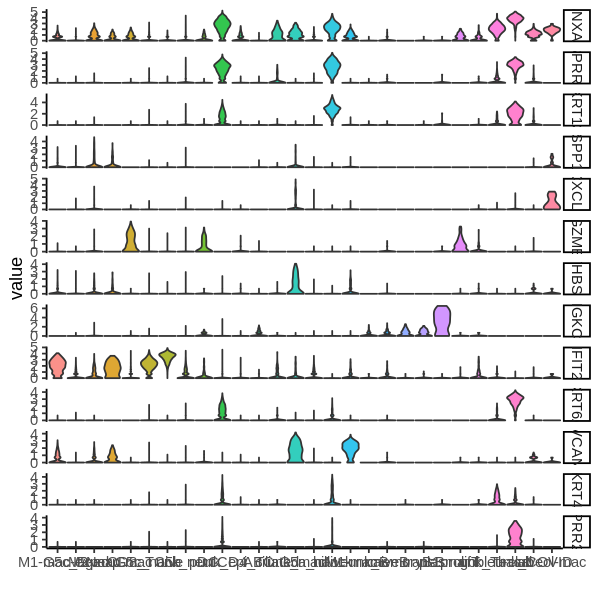

In [261]:
plot_vln(scNuc.pc30, feature)

In [337]:
my.colours = c("#313695", "#4575B4", "#74ADD1", "#ABD9E9", "#E0F3F8", "#FFFFFF", 
    "#FEE090", "#FDAE61", "#F46D43", "#D73027", "#A50026")
plot_heatmap = function(t, my.genes7, my.colours = my.colours, COL = T, ROW = T, 
    DEND = "none") {
    my.genes6 <- intersect(unique(my.genes7), rownames(t@assays$SCT@data))
    Mat <- t@assays$SCT@data[unique(my.genes6), ]
    Mat <- as.data.frame(as.matrix(Mat))
    Mat$gene <- rownames(Mat)
    Mat <- melt(Mat, id = "gene")
    Mat$cluster <- t@active.ident[Mat$variable]
    Mat <- Mat %>% group_by(gene, cluster) %>% dplyr::summarise(meanExp = mean(value)) %>% 
        ungroup
    Mat <- as.data.frame(Mat)
    Mat <- dcast(Mat, gene ~ cluster, value.var = "meanExp")
    rownames(Mat) <- Mat$gene
    Mat <- as.matrix(Mat[, -1])
    Mat <- t(scale(t(Mat)))
    Mat <- Mat[unique(my.genes6), levels(t@active.ident)]
    Mat <- na.omit(Mat)
    heatmap.2(Mat, Colv = COL, Rowv = ROW, dendrogram = DEND, scale = "none", 
        trace = "none", density.info = "none", col = my.colours)
}

In [338]:
table(scNuc.pc30@active.ident)


 M1-mac-exp    G5c_aged      M2-mac  IFNexp-mac       CD8_T   G5c_naive 
        866        3191         612         149         284        3816 
        G5b    unk_neut         pDC     unk_epi       CD4_T         ABC 
       1324        6164         127        3062         626         758 
   ciliated     unk_mac   G5a_naive     hillock      M1-mac       unk_B 
        148         281        3934         953         378         165 
     naiveB    memoryB1      transB      plasma     prolifT       unk_T 
        267         111         142          51         109         119 
goblet+club       basal   unk_COVID  alveol-mac 
        522         752         408          22 

In [339]:
Idents(scNuc.pc30) = 'cellType'

In [341]:
options(repr.plot.height = 7,repr.plot.width = 7)

`summarise()` has grouped output by 'gene'. You can override using the
`.groups` argument.


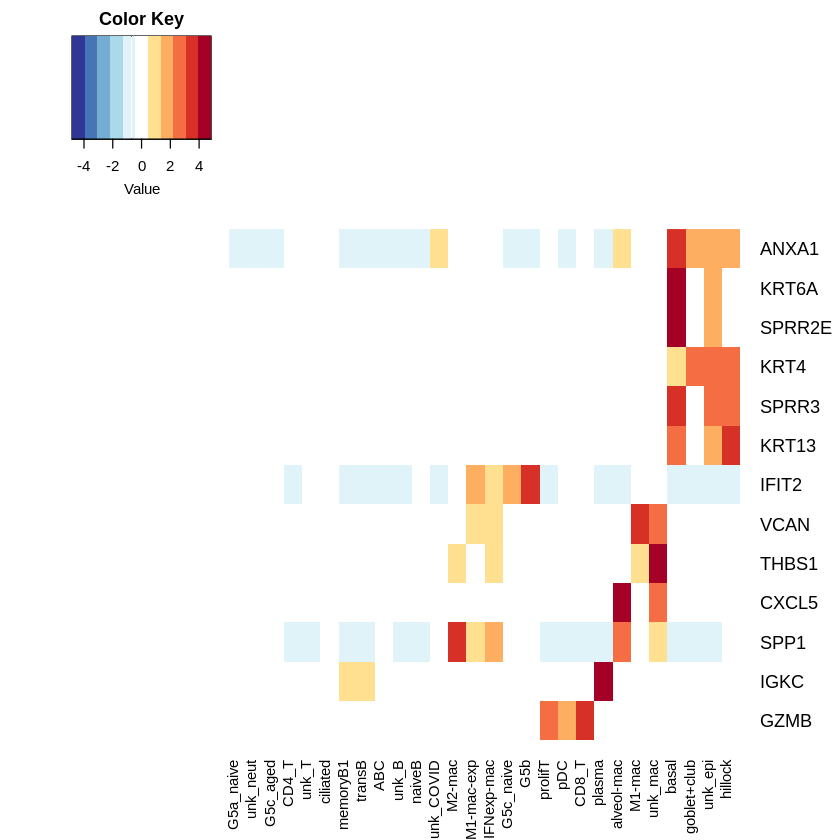

In [342]:
plot_heatmap(scNuc.pc30,feature,my.colours=my.colours,COL=T,ROW=T)

In [4]:
load('covid_combined2.rda')